# Neraul Network

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Normalization, BatchNormalization
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC, Precision, Recall
from imblearn.over_sampling import SMOTENC
from scikeras.wrappers import KerasClassifier

### Use the not transformed df as WOE supresses non-linear relationships.

In [6]:
train_df = pd.read_csv('train_df.csv',index_col=0)
test_df = pd.read_csv('test_df.csv',index_col=0)

Instead use dummy variables

In [7]:
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Combine so encoding goes correctly
combined = pd.concat([train_df, test_df], axis=0)

combined = pd.get_dummies(combined, drop_first=True) 
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

In [8]:
X_train = train_df.drop('stroke',axis=1)
y_train = train_df['stroke']

X_test = test_df.drop('stroke',axis=1)
y_test = test_df['stroke']

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4087 entries, 1604 to 4960
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          4087 non-null   float64
 1   hypertension                 4087 non-null   int64  
 2   heart_disease                4087 non-null   int64  
 3   avg_glucose_level            4087 non-null   float64
 4   bmi                          4087 non-null   float64
 5   ever_married_Yes             4087 non-null   bool   
 6   work_type_Never_worked       4087 non-null   bool   
 7   work_type_Private            4087 non-null   bool   
 8   work_type_Self-employed      4087 non-null   bool   
 9   work_type_children           4087 non-null   bool   
 10  smoking_status_never smoked  4087 non-null   bool   
 11  smoking_status_smokes        4087 non-null   bool   
dtypes: bool(7), float64(3), int64(2)
memory usage: 219.5 KB


### Since the dataset is so imbalanced, train data will be oversampled using SMOTEC

In [49]:
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto') 
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [11]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          7784 non-null   float64
 1   hypertension                 7784 non-null   int64  
 2   heart_disease                7784 non-null   int64  
 3   avg_glucose_level            7784 non-null   float64
 4   bmi                          7784 non-null   float64
 5   ever_married_Yes             7784 non-null   bool   
 6   work_type_Never_worked       7784 non-null   bool   
 7   work_type_Private            7784 non-null   bool   
 8   work_type_Self-employed      7784 non-null   bool   
 9   work_type_children           7784 non-null   bool   
 10  smoking_status_never smoked  7784 non-null   bool   
 11  smoking_status_smokes        7784 non-null   bool   
dtypes: bool(7), float64(3), int64(2)
memory usage: 357.4 KB


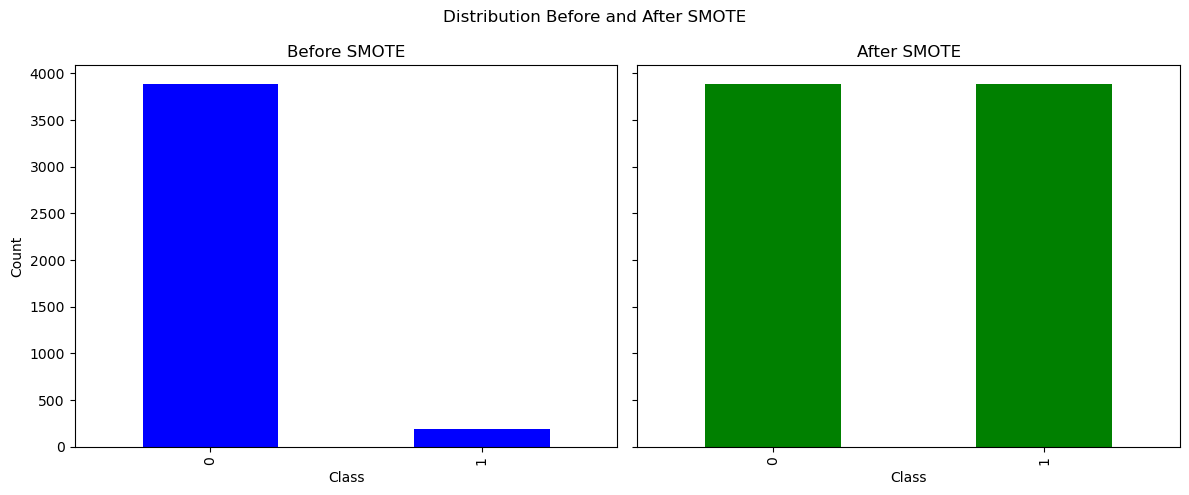

In [12]:
y_before = pd.Series(y_train)
y_after = pd.Series(y_train_resampled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Before resampling
y_before.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After resampling
y_after.value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')

plt.suptitle('Distribution Before and After SMOTE')
plt.tight_layout()
plt.show()

In [13]:
print("Class Proportions in % Before SMOTE:")
print(y_before.value_counts(normalize=True).sort_index() * 100)

print("\nClass Proportions in % After SMOTE:")
print(y_after.value_counts(normalize=True).sort_index() * 100)

Class Proportions in % Before SMOTE:
stroke
0    95.228774
1     4.771226
Name: proportion, dtype: float64

Class Proportions in % After SMOTE:
stroke
0    50.0
1    50.0
Name: proportion, dtype: float64


In [10]:
def build_model(input_dim=12, learning_rate=0.0003):
    model = Sequential([
    Dense(32, input_shape=(12,), activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[Recall(name='recall'),AUC(name='auc')] # I think its better to track the models recall instead of accuracy, since we want to catch all strokes
    )
    return model


In [11]:
model = build_model(input_dim=X_train.shape[1])
training = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=[X_test,y_test,],
    verbose=0
)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.9471624266144814
ROC AUC: 0.8074686256504439
Confusion Matrix:
 [[968   0]
 [ 54   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.00      0.00      0.00        54

    accuracy                           0.95      1022
   macro avg       0.47      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022



##### As we can see witout applying class weights, or oversampling the minority class the model only predicts 0, so we haven't detected any strokes

In [12]:
model = build_model(input_dim=X_train.shape[1])
training = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_data=[X_test,y_test,],
    verbose=0
)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.863013698630137
ROC AUC: 0.7716750841750842
Confusion Matrix:
 [[856 112]
 [ 28  26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       968
           1       0.19      0.48      0.27        54

    accuracy                           0.86      1022
   macro avg       0.58      0.68      0.60      1022
weighted avg       0.93      0.86      0.89      1022



In [13]:
def build_model(input_dim=12, learning_rate=0.0003):
    model = Sequential([
    Dense(64, input_shape=(12,), activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[Recall(name='recall'),AUC(name='auc')] # I think its better to track the models recall instead of accuracy, since we want to catch all strokes
    )
    return model

The model has a very simple architecture since the dataset is small, with only 11 features and less than 8000 observations after resampling.

In [14]:
model = build_model(input_dim=X_train.shape[1])
training = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_data=[X_test,y_test,],
    verbose=0
)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.3).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.589041095890411
ROC AUC: 0.769915059687787
Confusion Matrix:
 [[557 411]
 [  9  45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.58      0.73       968
           1       0.10      0.83      0.18        54

    accuracy                           0.59      1022
   macro avg       0.54      0.70      0.45      1022
weighted avg       0.94      0.59      0.70      1022



Lowering the treshold gave excellet recall, we are now detecting 83% of strokes, there is a tradeoff as now we are getting a lot of false positives however considering that a false positive in this context would only mean that a patient has to go throught an uneceseary medical test, compared to a potential death, I think it is clear what type of mistake is more important to avoid. Of course it is important to add that only 1 out of 10 patiens will be a true positive.

#### Lets try to lower the threshold even further to maybe achieve a  higher TPR

In [22]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.275).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
Accuracy: 0.5724070450097848
ROC AUC: 0.769915059687787
Confusion Matrix:
 [[538 430]
 [  7  47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.56      0.71       968
           1       0.10      0.87      0.18        54

    accuracy                           0.57      1022
   macro avg       0.54      0.71      0.44      1022
weighted avg       0.94      0.57      0.68      1022



Now we have achieved an even better rate of detecting strokes, without a noticeable impact on precision. We missed 7 patients that had a stroke.

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,837 (34.52 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,892 (23.02 KB)

### Grid Search

In [15]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np


def build_model(learning_rate=0.0003, 
                dropout_rate=0.2, 
                layer_sizes=[64, 32], 
                use_batch_norm=False,
                activation='relu'):
    model = Sequential()
    
    model.add(Dense(layer_sizes[0], input_shape=(12,), activation=activation))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for size in layer_sizes[1:]:
        model.add(Dense(size, activation=activation))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[Recall(name='recall'), AUC(name='auc')]
    )
    return model


model = KerasClassifier(
    model=build_model,
    verbose=0
)


param_grid = {
    'model__learning_rate': [0.0001, 0.0003, 0.001],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'model__layer_sizes': [
        [64, 32],
        [128, 64],
        [64, 64, 32],
        [128, 64, 32]
    ],
    'model__use_batch_norm': [True, False],
    'batch_size': [32, 64, 128],
    'epochs': [20]
}


grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2
)


grid_result = grid.fit(X_train_resampled, y_train_resampled)


print(f"\nBest: {grid_result.best_score_:.4f} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.4f} ({stdev:.4f}) with: {param}")


best_model = grid_result.best_estimator_.model_
y_pred_probs = best_model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.3).astype(int)

print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=0.0001, model__use_batch_norm=True; total time=   6.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=0.0001, model__use_batch_norm=True; total time=   5.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=0.0001, model__use_batch_norm=True; total time=   6.0s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=0.0001, model__use_batch_norm=False; total time=   4.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=0.0001, model__use_batch_norm=False; total time=   4.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.1, model__layer_sizes=[64, 32], model__learning_rate=

In [19]:
best_model = grid_result.best_estimator_.model_
y_pred_probs = best_model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.2).astype(int)

print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

Test Set Performance:
Accuracy: 0.6281800391389433
ROC AUC: 0.7789064891337618
Confusion Matrix:
 [[598 370]
 [ 10  44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76       968
           1       0.11      0.81      0.19        54

    accuracy                           0.63      1022
   macro avg       0.54      0.72      0.47      1022
weighted avg       0.94      0.63      0.73      1022



In [43]:
def build_final_model():
    model = Sequential()
    
    # Input layer
    model.add(Dense(128, input_shape=(12,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[Recall(name='recall'), AUC(name='auc')]
    )
    
    return model

In [50]:
final_model = build_final_model()
final_model.fit(
    X_train_resampled, 
    y_train_resampled, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_test, y_test),  # optional
    verbose=0
)

In [52]:
y_pred_probs = final_model.predict(X_test)
y_pred = (y_pred_probs > 0.275).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.7367906066536204
ROC AUC: 0.723561371288644
Confusion Matrix:
 [[726 242]
 [ 27  27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84       968
           1       0.10      0.50      0.17        54

    accuracy                           0.74      1022
   macro avg       0.53      0.62      0.51      1022
weighted avg       0.92      0.74      0.81      1022



The previous model was better

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,837 (34.52 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,892 (23.02 KB)

This is the final proposed model

In [22]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.275).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
Accuracy: 0.5724070450097848
ROC AUC: 0.769915059687787
Confusion Matrix:
 [[538 430]
 [  7  47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.56      0.71       968
           1       0.10      0.87      0.18        54

    accuracy                           0.57      1022
   macro avg       0.54      0.71      0.44      1022
weighted avg       0.94      0.57      0.68      1022



### Trying to explain the model's predictions using Shap values

In [17]:
import shap

sample = X_train_resampled.sample(1000, random_state=42).astype(np.float32)
test_sample = X_test.sample(100, random_state=42).astype(np.float32)

explainer = shap.Explainer(model, sample)

shap_values = explainer(test_sample)

PermutationExplainer explainer: 101it [00:10,  1.18it/s]                        


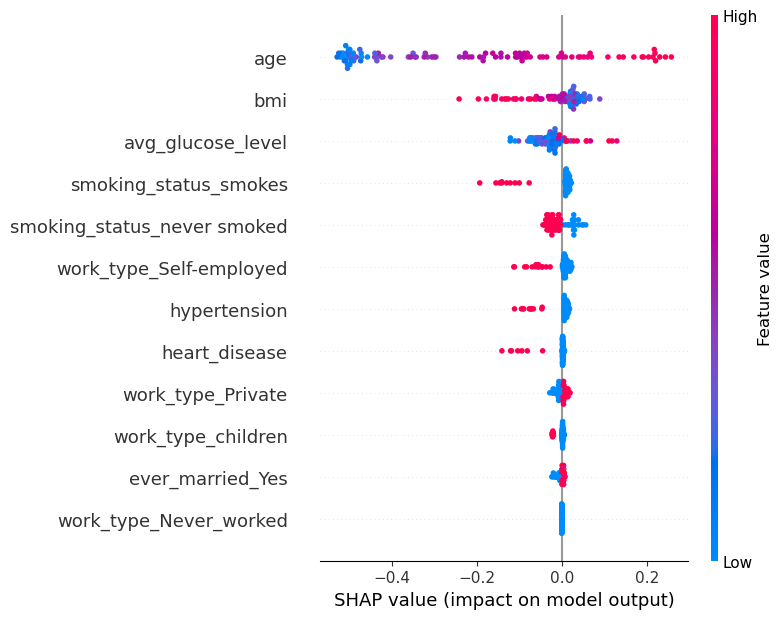

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

shap.summary_plot(shap_values, test_sample, feature_names=test_sample.columns, show=False)
plt.tight_layout()



##### As we can see from this interpretations in this case SHAP values results suggest that the model learned interactions between features that are different to what should be  excpected based on medicine. For example people with hypertension or heart disease had a lower risk, people with high bmi also had a lower risk. Some values such as age or glucose levels showed results as excepted. This suggested that some of the relathionships captured by the model may be dataset specific rather than general, despite that the model still reached a very high rate of predicting strokes. Which I think also shows the trade-off between model expleinability and it's predictive power.

### Short Summary

##### The metrics of the model suggest that the model's best use would be as as preliminary screening tool, it wouldn't be good as a diagnostic tool since it is gives too many false positvies. However combining this model with further use of medical exams which have a higher precision would be an excellent solution for detecting strokes.